In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', color_codes=True)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

In [ ]:
con_rev = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 
print(con_rev.shape)
con_rev.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
#filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

In [ ]:
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
subset = {"UserId", "ProfileName", "Time", "Text"}
data = filtered_data.drop_duplicates(subset=subset, keep="first")
print(data.shape)
data.head(3)

(364173, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
#Checking to see how much % of data still remains
(data['Id'].size)/(filtered_data['Id'].size)*100

69.25890143662969

In [ ]:
#Checking IS 'HelpfulnessNumerator' always less than or equal to 'HelpfulnessDenominator' ?
data[data['HelpfulnessNumerator'] > data['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [ ]:
#"HelpfulnessNumerator" can't be grater than "HelpfulnessDenominator"
#so taking dataframe inwhich "HelpfulnessNumerator" less than or equal to "HelpfulnessDenominator"

data = data[data['HelpfulnessNumerator'] <= data['HelpfulnessDenominator']]
data.reset_index(drop = True, inplace=True)
print(data.shape)
data.head(3)

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
#Identifing missing Values
miss_val = data.isna().sum()
miss_val

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

1    307061
0     57110
Name: Score, dtype: int64
**************************************************


Text(0.5, 1.0, 'Score distribution')

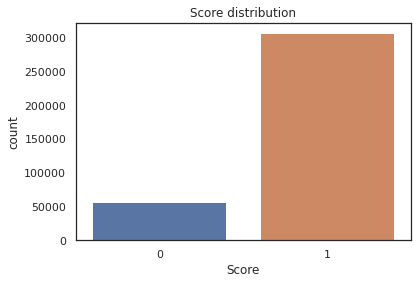

In [ ]:
#data points for each class
print(data['Score'].value_counts())
print("*"*50)

#Count plot for Score
sns.countplot('Score',data = data)
plt.title("Score distribution")

In [ ]:
#set of stopwords
import re
import nltk
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')                      


#function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext



#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


#function to text summarization
def final_sentence(text):
    
    text = text.split()
    text = [cleanhtml(x) for x in text]
    text = [cleanpunc(x) for x in text]
    
    def test(word):
        if word.isalpha() and len(word) > 2 and word.lower() not in stop:
            return True
        else:
            return False
    
    text = [x for x in text if test(x)]
    
    return ' '.join(text)

In [ ]:
data['CleanedText'] = data['Text'].apply(final_sentence)
print(data.shape)
data.head()

NameError: ignored

In [ ]:
def Text_Into_Vector(model,data):
    model_vect = model(ngram_range=(1,2)) #in scikit-learn
    final_array = model_vect.fit_transform(data.values)

    print("the type of count vectorizer ",type(final_array))
    print("the shape of out text BOW vectorizer ",final_array.get_shape())
    print("the number of unique words including both unigrams and bigrams ", final_array.get_shape()[1])
    
    return model_vect, final_array

In [ ]:

#split data into train, cross validate and test 
from sklearn.model_selection import train_test_split

def Split_data(x_vec, y_vec):
    X_train, X_test, Y_train, Y_test = train_test_split(x_vec, y_vec, test_size=.33, random_state=0)
    X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)
    return X_tr, X_cv, X_test, Y_tr, Y_test, Y_cv, X_train, Y_train

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

def Normalization(train, cv, test):
    train=preprocessing.normalize(train)
    cv=preprocessing.normalize(cv)
    test=preprocessing.normalize(test)

    print("Train Data Size ",train.get_shape())
    print("CV Data Size: ",cv.shape)
    print("Test Data Size: ",test.shape)
    
    return train, cv, test

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pylab as pyplt

def Multinomial_NB(X_train,X_cv,Y_train,Y_cv):
    #############################################################################
    best_alpha=0
    max_roc_auc=-1
    pred_cv = []
    pred_train = []
    alpha=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
    #############################################################################

    for i in alpha:
        mulbnb = MultinomialNB(alpha=i)
        mulbnb.fit(X_train,Y_train)
        probs = mulbnb.predict_proba(X_cv)[:,1]     
        prob = mulbnb.predict_proba(X_train)[:,1]
        #############################################################################

        auc_score_cv = roc_auc_score(Y_cv,probs)            #auc roc for cv
        auc_score_train = roc_auc_score(Y_train,prob)       #auc roc for train
        #############################################################################

        print(i," ------> ",auc_score_cv)
        #############################################################################

        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        #############################################################################

        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            best_alpha=i

    print("*"*100)
    print(f"\n Best alpha Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
    print("*"*100)
    #############################################################################

    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(alpha, pred_cv,'r-', label = 'CV Data')
    plt.plot(alpha,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\alpha$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()
    print("*"*100)
    #############################################################################

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_cv,probs)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    pyplt.title("Line Plot of ROC Curve on Train Data")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()
    print("*"*100)
    
    #############################################################################
    return best_alpha

In [ ]:
import scikitplot.metrics as skplt
from sklearn import metrics
from sklearn.metrics import confusion_matrix


def Testing_model(X_train,Y_train,X_test,Y_test,best_alpha):
    
    #############################################################################
    bnb = MultinomialNB(alpha = best_alpha, fit_prior=True, class_prior=None)
    bnb.fit(X_train,Y_train)
    probs = bnb.predict_proba(X_test)[:,1]            # keep probabilities for the positive outcome only

    #############################################################################
    roc_auc = roc_auc_score(Y_test,probs)
    print("AUC Score",roc_auc)
    print("*"*70)
    #############################################################################'

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()

    #############################################################################
    prediction=bnb.predict(X_test)
    skplt.plot_confusion_matrix(Y_test,prediction)
    #############################################################################

    print("macro f1 score for data :",metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 score for data:",metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("*"*70)
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))
    print("*"*70)
    
    return bnb,roc_auc

    #############################################################################

ModuleNotFoundError: ignored

In [ ]:
def Important_features(model, classifier):
    neg = classifier.feature_log_prob_[0].argsort()
    pos = classifier.feature_log_prob_[1].argsort()
    top_pos_words = np.take(model.get_feature_names(),pos)
    top_neg_words = np.take(model.get_feature_names(),neg)
    imp_df = pd.DataFrame(columns = ['Pos_Words','Pos_Importance','Neg_Words','Neg_Importance'])
    imp_df['Pos_Words'] = top_pos_words[::-1]
    imp_df['Pos_Importance'] = np.take(classifier.feature_log_prob_[1],pos)[::-1]
    imp_df['Neg_Words'] = top_neg_words[::-1]
    imp_df['Neg_Importance'] = np.take(classifier.feature_log_prob_[0],neg)[::-1]
    return imp_df

In [ ]:

def Individual_Prediction(model, classifier, review):
    review = final_sentence(review)
    review_vec = model.transform([review])
    review_vec = preprocessing.normalize(review_vec)
    pred = classifier.predict(review_vec)

    return "positive review" if pred[0] == 1 else "negative review"

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

BOW, X = Text_Into_Vector(CountVectorizer,data['CleanedText'])

In [ ]:
BOW.get_feature_names()[:20]

In [ ]:
BOW.get_params()

In [ ]:

#split data into train, cross validate and test 

X_tr, X_cv, X_test, Y_tr, Y_test, Y_cv, X_train, Y_train = Split_data(X, data['Score'])

In [ ]:
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)
print('X_Train, Y_Train', X_train.shape, Y_train.shape)

In [ ]:
# Normalization

X_tr, X_cv, X_test = Normalization(X_tr, X_cv, X_test)

In [ ]:
#training NB 

best_alpha_bow = Multinomial_NB(X_tr,X_cv,Y_tr,Y_cv)

In [ ]:
# Testing NB Model

NB_bow, roc_auc_bow = Testing_model(X_tr,Y_tr,X_test,Y_test,best_alpha_bow)

In [ ]:
# Top features using NB and BOW

Important_features(BOW, NB_bow)

In [ ]:
## TFidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

TfIdf, X = Text_Into_Vector(TfidfVectorizer,data['CleanedText'])

In [ ]:
TfIdf.get_params()

In [ ]:
#split data into train, cross validate and test 

X_tr, X_cv, X_test, Y_tr, Y_test, Y_cv, X_train, Y_train = Split_data(X, data['Score'])

In [ ]:
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)
print('X_Train, Y_Train', X_train.shape, Y_train.shape)

In [ ]:

# Normalize Data

X_tr, X_cv, X_test = Normalization(X_tr, X_cv, X_test)

In [ ]:
#Training NB model

best_alpha_idf = Multinomial_NB(X_tr,X_cv,Y_tr,Y_cv)

In [ ]:

# Testing NB Model

NB_tfidf, roc_auc_idf = Testing_model(X_tr,Y_tr,X_test,Y_test,best_alpha_idf)

In [ ]:
# Top features using NB and tfidf

Important_features(TfIdf, NB_tfidf)

In [ ]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperameter(alpha)","Test Auc Score"]

####################################################################################
x.add_row(["BoW","MultinomialNB",best_alpha_bow, roc_auc_bow])
x.add_row(["Tf-Idf","MultinomialNB",best_alpha_idf, roc_auc_idf])

####################################################################################
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
####################################################################################
printmd('****Final Conclusion for MultiNomialNB Model:****')
print(x)

In [ ]:

# Individual prediction
review = """Great, healthier alternative to the usual bhujia we Indians are used to having along with our tea or our beer.
            Much less salt than traditional tea snacks as well. I love the variety of texture as well with the very 
            crunchy peas to soft cheese bits, the sesame seed coated snack to good old roasted peanuts. It is pretty 
            expensive though, at 600rs at a kilo perhaps the most expensive tea snack Ive ever had."""

print("Prediction using BOW:", Individual_Prediction(BOW, NB_bow, review))
print("Prediction using TF-Idf:", Individual_Prediction(TfIdf, NB_tfidf, review))